In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [131]:
import os
from pathlib import Path
import pymc as pm
import arviz as az

In [132]:
path = Path("/home/leonardo/.cache/kagglehub/datasets/sudalairajkumar/novel-corona-virus-2019-dataset/versions/151")
print("Path to dataset files:", path)

Path to dataset files: /home/leonardo/.cache/kagglehub/datasets/sudalairajkumar/novel-corona-virus-2019-dataset/versions/151


### Observe & preprocess

In [177]:
datasets = {
    "confirm": pd.read_csv(path/'time_series_covid_19_confirmed.csv'),
    "recover": pd.read_csv(path/'time_series_covid_19_recovered.csv'),
    "deaths": pd.read_csv(path/'time_series_covid_19_deaths.csv'),
}

In [178]:
datasets["confirm"].head(3)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,64575,65080,65486,65728,66275,66903,67743,68366,69130,70111
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,132118,132153,132176,132209,132215,132229,132244,132264,132285,132297
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,126156,126434,126651,126860,127107,127361,127646,127926,128198,128456


Структура датасета следующая:
- Страна
- Штат / провинция
- Широта
- Долгота

А дальше много столбцов, 1 столбец == 1 день, для которого указано **кумулятивное значение** подтверждённых случаев / выздоровлений / смертей (3 отдельных датасета) 

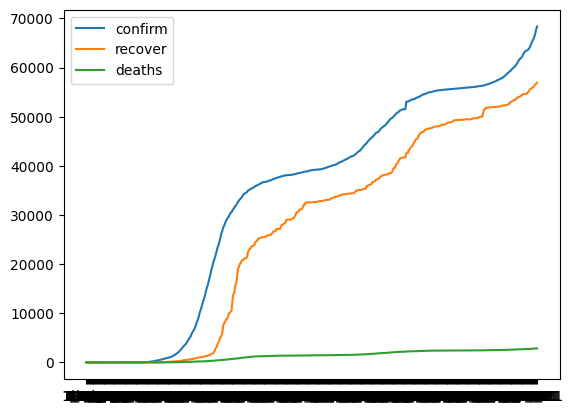

In [179]:
for key in datasets:
    plt.plot(datasets[key].iloc[0, 2:-2], label=key)

plt.legend()
plt.show()

### На что интереснее смотерть
Вообще кумулятивные значения - это хорошо, но интереснее разности (например, *сколько заболело* в такой-то день). Поэтому давайте перейдём к разностям

In [180]:
dfs = {}

for key in datasets:
    vals = np.array(datasets[key].iloc[:, 4:]) - np.hstack([np.zeros([len(datasets[key]), 1]), np.array(datasets[key].iloc[:, 4:-1])])
    dfs[key] = pd.concat([
        datasets[key][["Country/Region", "Province/State", "Lat", "Long"]],
        pd.DataFrame(vals, index=datasets[key].index, columns=datasets[key].columns[4:])
    ], axis=1)
    
    print(f"{key}: {dfs[key].shape}")

confirm: (276, 498)
recover: (261, 498)
deaths: (276, 498)


In [181]:
dfs["confirm"].head()

,Country/Region,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21
0,Afghanistan,NaN,33.93911,67.709953,0.0,0.0,0.0,0.0,0.0,0.0,...,453.0,505.0,406.0,242.0,547.0,628.0,840.0,623.0,764.0,981.0
1,Albania,NaN,41.15330,20.168300,0.0,0.0,0.0,0.0,0.0,0.0,...,23.0,35.0,23.0,33.0,6.0,14.0,15.0,20.0,21.0,12.0
2,Algeria,NaN,28.03390,1.659600,0.0,0.0,0.0,0.0,0.0,0.0,...,260.0,278.0,217.0,209.0,247.0,254.0,285.0,280.0,272.0,258.0
3,Andorra,NaN,42.50630,1.521800,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,95.0,7.0,11.0,11.0,0.0
4,Angola,NaN,-11.20270,17.873900,0.0,0.0,0.0,0.0,0.0,0.0,...,223.0,248.0,240.0,292.0,182.0,310.0,405.0,269.0,337.0,236.0


### Отрицательные значения
В данных есть отрицаьтельные значения, которые по сути означают, что в какой-то момент заболевших / выздоровевших / умерших стало меньше. Так, конечно, не бывает

Менее заметная, но на самом деле симметричная ситуация: резкие скачки вверх. "Резкозть" надо формализовать, но на графиках (в нижнем ряду) хорошо видно, о чём речь

Пример с выздоровлениям в США, заболеваниями во Франции и смертями в Испании:

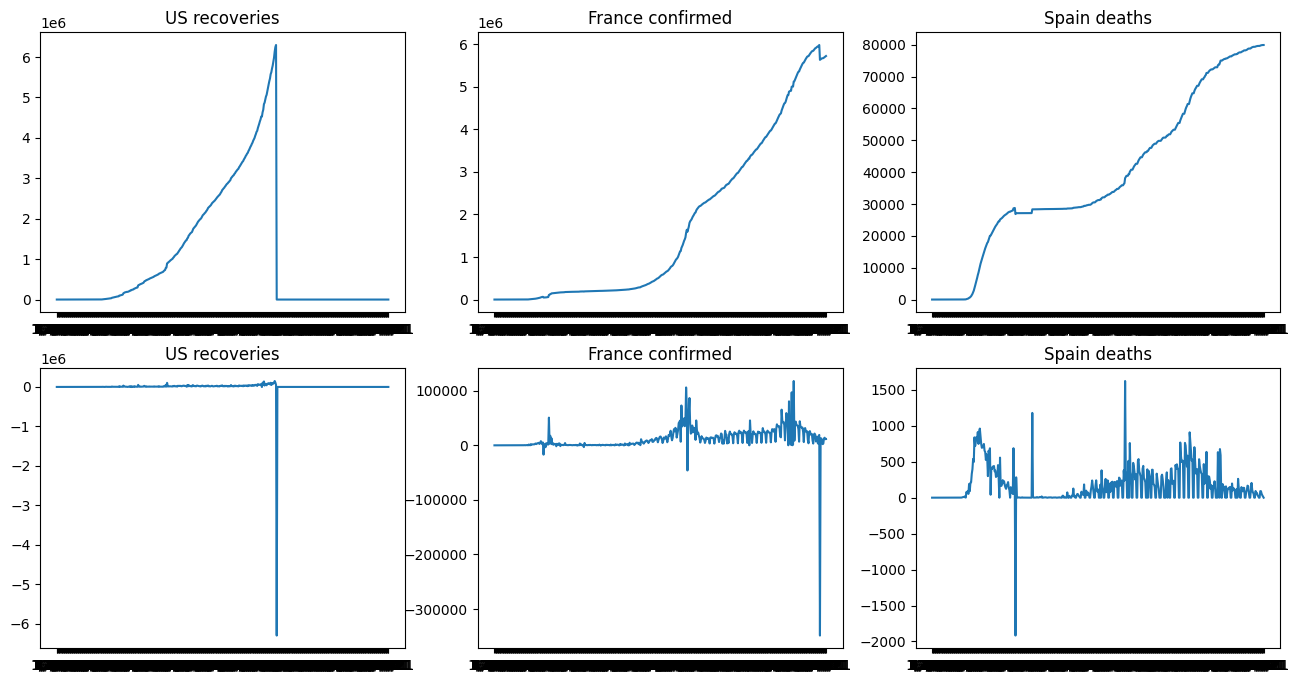

In [182]:
fig, ax = plt.subplots(2, 3, figsize=(16, 8))

for i, data_dict in enumerate((datasets, dfs)):
    d = data_dict["recover"].drop(columns=["Lat", "Long", "Province/State"]).groupby("Country/Region", as_index=False).sum()
    d = d[d["Country/Region"] == "US"]
    ax[i, 0].plot(d.iloc[0, 1:])
    ax[i, 0].set_title("US recoveries")
    
    d = data_dict["confirm"].drop(columns=["Lat", "Long", "Province/State"]).groupby("Country/Region", as_index=False).sum()
    d = d[d["Country/Region"] == "France"]
    ax[i, 1].plot(d.iloc[0, 1:])
    ax[i, 1].set_title("France confirmed")
    
    d = data_dict["deaths"].drop(columns=["Lat", "Long", "Province/State"]).groupby("Country/Region", as_index=False).sum()
    d = d[d["Country/Region"] == "Spain"]
    ax[i, 2].plot(d.iloc[0, 1:])
    ax[i, 2].set_title("Spain deaths")

plt.show()

Здесь видно, что иногда данные как будто просто перестают приходить

Посмотрим, для каких стран актуальна проблема, выведем страны, для которых кумулятивные суммы в конце оказываются равны 0:

In [183]:
for key in datasets:
    d = datasets[key].drop(columns=["Lat", "Long", "Province/State"]).groupby("Country/Region", as_index=False).sum()
    print(key, d.loc[d["5/29/21"] == 0, "Country/Region"].values.tolist())

confirm []
recover ['Belgium', 'Kiribati', 'Serbia', 'Sweden', 'US']
deaths ['Dominica', 'Holy See', 'Kiribati', 'Marshall Islands', 'Micronesia', 'Saint Kitts and Nevis', 'Samoa', 'Solomon Islands']


#### Предсказываем заболевания

Наш таргет - это заболевания, что удачно: только для заболеваний нет проблемы "исчезновения" данных с какого-то момента (как в случае с выздоровлениями в США)

Посмотрим теперь на отрицательные значения для заболеваний (*confirmed*)

In [184]:
bads = {}

for key in dfs:
    d = dfs[key].drop(columns=["Lat", "Long", "Province/State"]).groupby("Country/Region", as_index=False).sum()
    if "Country" not in bads:
        bads["Country"] = d["Country/Region"].values
    
    vals = d.iloc[:, 1:].values
    mins = vals.min(axis=1)
    counts = (vals < 0).sum(axis=1)
    bads[f"{key}_min"] = mins
    bads[f"{key}_cnt"] = counts

bads = pd.DataFrame(bads)
# bads.sort_values(by="deaths_cnt", ascending=False, inplace=True)
# bads.sort_values(by="recover_min", ascending=True, inplace=True)
bads.sort_values(by=["confirm_cnt", "confirm_min"], ascending=[False, True], inplace=True)
bads.head(40)

,Country,confirm_min,confirm_cnt,recover_min,recover_cnt,deaths_min,deaths_cnt
62,France,-348667.0,10,-518.0,2,-217.0,7
52,Ecuador,-7953.0,4,-11062.0,1,0.0,0
173,Thailand,-10.0,4,-11.0,4,0.0,0
126,New Zealand,-2.0,4,-1.0,2,0.0,0
163,Spain,-74347.0,3,0.0,0,-1918.0,2
183,United Kingdom,-4787.0,2,-322.0,3,0.0,0
180,Uganda,-104.0,2,-113.0,1,0.0,0
84,Israel,-53.0,2,-269.0,1,-4.0,1
149,San Marino,-19.0,2,0.0,0,0.0,0
61,Finland,-5.0,2,-200.0,1,-4.0,6


Для **39** стран есть подозрительные отрицательные скачки

И иногда это **совпадает с политическими событиями**:
- 14 декабря 2020 года в США стало на 6 млн выздоровлений меньше. В этот день был избран Джо Байден
- 25 мая 2020 года в Испании стало меньше смертей - примерно на 2 тыс. В этот день Мадрид и Барселова смягчили антиковидным меры
- Во Франции 20 мая 2021 года стало на 350 тыс. заболеваний меньше. Также в этот день объявили о вакцинации с 31 мая
- В Великобритании 9 апреля 2021 года состоялся траур по принцу Филиппу. В этот день заражений стало почти на 5 тыс. меньше
- 22 марта 2021 года в Чехии звонили в колокола в память о жертвах короны. Заражений стало меньше на 2 тысячи

Не всегда понятно, как политика влияет на цифры, но некоторые совпадения очень интересны. Как быть с отрицательными значениями?
Мы рассмотрели **2 идеи**:
1. Если в какой-то день прирост отрицательный, "размажем" его по нескольким предыдущим
2. Если прирост отрицательный, назначим его равным среднему приросту на окрестности

Для начала решили остановиться на последнем варианте, потому что он меняет данные локально только в проблемных точках, не затрагивая остальные. Этот подход также соответствует **одному наблюдению**:

**Ситуация**

*Франция, май 2021 года*

На сайте https://www.worldometers.info/coronavirus/country/france/ есть динамика заболеваемости. Интересующая дата - 20 мая 2021 года, суммарно 5'568'551 заражение, в датасете же значение равно 5'629'983. Не совпадает, но довольно близко.

Но 20 мая 2021 года в нашем датасете (см. ячейку ниже) произошёл скачок вниз на 350к, и показания на сайте до 20 мая уже сильно расходятся с датасетом. Из этого следует гипотеза: вероятно, над статистикой иногда происходили некоторые махинации, о которых мы никогда не узнаем. Вероятно, статистика была пересчитана за всеь период времени, в то время как старые значения датасета обновлены не были. Это объясняет наличие скачков.

Что делать? Так как нас интересуют не кумулятивные показатели, а приросты (сколько заболело за день), можно исправить экстремальные значения приростов, заменив их на среднее по окрестности

In [185]:
d = datasets["confirm"]
d[d["Country/Region"] == "France"].loc[:, ["5/18/21", "5/19/21", "5/20/21", "5/21/21", "5/22/21"]]

,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21
119,21845,21845,22115,22382,22610
120,18828,18835,18841,18844,18844
121,16079,16079,16079,16079,16079
122,11669,11669,11669,11669,11669
123,20176,20176,20176,20176,20176
124,125,125,125,125,125
125,22644,23566,23566,23566,23566
126,974,974,1005,1005,1005
127,25,25,25,25,25
128,1773,1773,1915,1915,1915


In [186]:
df = dfs["confirm"].copy()
print(df.shape)
df.head()

(276, 498)


,Country/Region,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21
0,Afghanistan,NaN,33.93911,67.709953,0.0,0.0,0.0,0.0,0.0,0.0,...,453.0,505.0,406.0,242.0,547.0,628.0,840.0,623.0,764.0,981.0
1,Albania,NaN,41.15330,20.168300,0.0,0.0,0.0,0.0,0.0,0.0,...,23.0,35.0,23.0,33.0,6.0,14.0,15.0,20.0,21.0,12.0
2,Algeria,NaN,28.03390,1.659600,0.0,0.0,0.0,0.0,0.0,0.0,...,260.0,278.0,217.0,209.0,247.0,254.0,285.0,280.0,272.0,258.0
3,Andorra,NaN,42.50630,1.521800,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,95.0,7.0,11.0,11.0,0.0
4,Angola,NaN,-11.20270,17.873900,0.0,0.0,0.0,0.0,0.0,0.0,...,223.0,248.0,240.0,292.0,182.0,310.0,405.0,269.0,337.0,236.0


Сделаем преобразование последовательности

In [187]:
def smooth_sequence(vals, d=7, c=3):
    v = np.concatenate([[0] * d, vals, [0] * d])
    means = np.array([(v[i - d: i].mean() + v[i + 1: i + d + 1].mean()) // 2 for i in range(d, len(vals) + d)])
    maxes = np.array([max(v[i - d: i].max(),
                          v[i + 1: i + d + 1].max()) for i in range(d, len(vals) + d)])
    mask = (vals < 0) | (vals > maxes * c)
    return np.where(mask, means, vals)


def df_transform(row):
    row.iloc[4:] = smooth_sequence(row.iloc[4:].values)
    return row

In [188]:
df = df.apply(df_transform, axis=1)
print(df.shape)
df.head()

(276, 498)


,Country/Region,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21
0,Afghanistan,NaN,33.93911,67.709953,0.0,0.0,0.0,0.0,0.0,0.0,...,453.0,505.0,406.0,242.0,547.0,628.0,840.0,623.0,764.0,981.0
1,Albania,NaN,41.15330,20.168300,0.0,0.0,0.0,0.0,0.0,0.0,...,23.0,35.0,23.0,33.0,6.0,14.0,15.0,20.0,21.0,12.0
2,Algeria,NaN,28.03390,1.659600,0.0,0.0,0.0,0.0,0.0,0.0,...,260.0,278.0,217.0,209.0,247.0,254.0,285.0,280.0,272.0,258.0
3,Andorra,NaN,42.50630,1.521800,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,7.0,11.0,11.0,0.0
4,Angola,NaN,-11.20270,17.873900,0.0,0.0,0.0,0.0,0.0,0.0,...,223.0,248.0,240.0,292.0,182.0,310.0,405.0,269.0,337.0,236.0


/tmp/ipykernel_219441/2910338916.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  d = df.drop(columns=["Lat", "Long", "Province/State"]).groupby("Country/Region", as_index=False).sum()


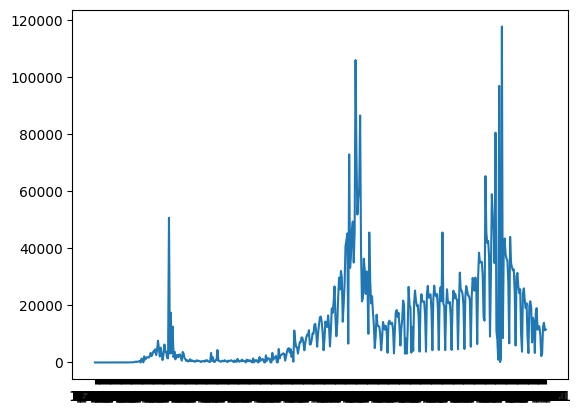

In [189]:
d = df.drop(columns=["Lat", "Long", "Province/State"]).groupby("Country/Region", as_index=False).sum()
d = d[d["Country/Region"] == "France"]
plt.plot(d.iloc[0, 1:], label="France confirmed")

plt.show()

In [192]:
df.to_csv("data/confirmed_daily.csv", index=False)